# Crawford model

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import arviz as az
import seaborn as sns
sns.set()

import sys  
import pickle
sys.path.insert(0, '../scripts/')
from tqdm.notebook import tqdm

from crawford_algorithm import simulating_rds_crawford, Crawford
from artificial_data import GenerateData
from scipy.special import logit, expit

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## Model

In [4]:
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_v5.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_v5.pkl', 'wb') as f:
        pickle.dump(sm, f)

## Sampling from Crawford's model

In [5]:
graph = nx.gnp_random_graph(n=20, p=0.25, seed=31290)
data = simulating_rds_crawford(graph, n_samples=10, n_seeds=1, rate=1, probs=[0, 1/6, 1/6, 2/3], seed=312321)

100%|██████████| 9/9 [00:00<00:00, 8657.97it/s]


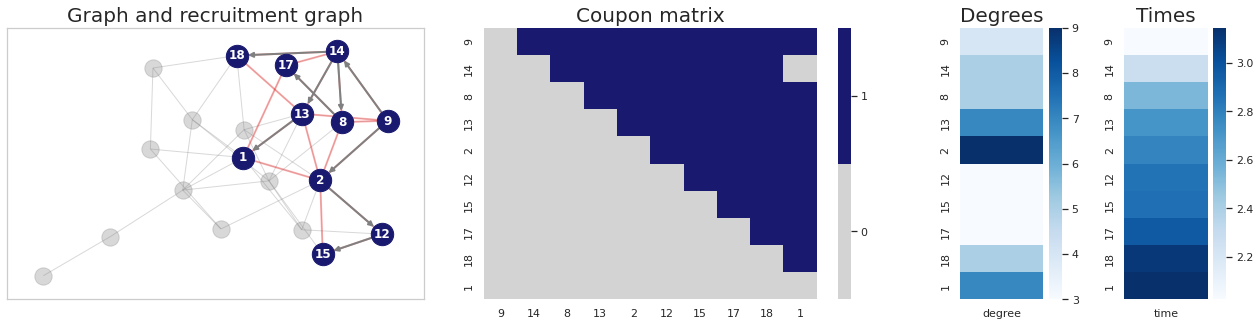

In [183]:
options = {
    'node_color': 'midnightblue',
    'node_size': 500,
    'with_labels': True,
    'font_weight': 'bold',
    'font_color': 'white',
    'edge_color': 'grey',
    'width': 2
}

sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 4, figsize = (18,5), gridspec_kw={'width_ratios': [8, 8, 2, 2]})
pos = graphviz_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_color='grey', alpha=0.3, ax=ax[0])
nx.draw_networkx_edges(graph, pos, edge_color='grey', alpha=0.3, ax=ax[0])
nx.draw_networkx_edges(graph.subgraph(data['rds'].nodes), pos, edge_color='red', alpha=0.3, width=2, ax = ax[0])
nx.draw_networkx(data['rds'], pos, **options, ax=ax[0])
ax[0].grid(False)

colors = ('lightgrey', 'midnightblue')
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
sns.heatmap(pd.DataFrame(data['C'], columns=list(data['rds'].nodes), index=list(data['rds'].nodes)), 
            ax=ax[1], cmap=cmap)
colorbar = ax[1].collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['0', '1'])

sns.heatmap(pd.DataFrame(nx.get_node_attributes(data['rds'], 'degree').values(), 
                         columns=['degree'], index=nx.get_node_attributes(data['rds'], 'degree').keys()), 
            ax=ax[2], cmap='Blues')
sns.heatmap(pd.DataFrame(nx.get_node_attributes(data['rds'], 'time').values(), 
                         columns=['time'], index=nx.get_node_attributes(data['rds'], 'time').keys()), 
            ax=ax[3], cmap='Blues')

ax[0].set_title('Graph and recruitment graph', fontsize=20)
ax[1].set_title('Coupon matrix', fontsize=20)
ax[2].set_title('Degrees', fontsize=20)
ax[2].set_xlabel('')
ax[3].set_title('Times', fontsize=20)
ax[3].set_xlabel('')

fig.tight_layout(pad = 2)
plt.savefig('../images/crawford_mode_example.pdf', bbox_inches = 'tight')
plt.show()

sns.set()

In [5]:
graph = nx.gnp_random_graph(n=10000, p=0.005, seed=421412)
data = simulating_rds_crawford(graph, n_samples=500, n_seeds=3, rate=1/5, probs=[1/3, 1/6, 1/6, 1/3], seed=421412)

100%|██████████| 499/499 [00:00<00:00, 1276.30it/s]


In [43]:
def simulation(n_samples, rule, parameters_rule, rho, tau, RDS_R=0,
               prevalence=0.1, gamma_s=0.9, gamma_e=0.8, beta=np.array([-0.1, 2.5, 1.4, -1.8, 0.3]),
               n_pred_cont=3, n_pred_binary=2, seed=63289371):
    
    ro = np.random.RandomState(seed)
    
    gen_graph = GenerateData()
    graph = gen_graph.random_graph(rule=rule, 
                                   parameters=parameters_rule)
    rds_sample = simulating_rds_crawford(graph, n_samples=n_samples, n_seeds=10, 
                                         rate=1/5, probs=[1/3, 1/6, 1/6, 1/3], seed=421412)
    rds_sample['rds'].remove_nodes_from(list(nx.isolates(rds_sample['rds'])))
    G_S = graph.subgraph(rds_sample['rds'].nodes)
    A = nx.adjacency_matrix(G_S.to_undirected()).toarray()
    n_samples = rds_sample['rds'].number_of_nodes()
    D = np.diag(A.sum(axis = 1))
    
    n_predictors = n_pred_cont + n_pred_binary
    x = np.zeros((n_samples, n_predictors))
    x[:, :n_pred_cont] = ro.multivariate_normal(mean = np.zeros(n_pred_cont), 
                                                cov = np.eye(n_pred_cont),
                                                size = n_samples)
    x[:, :n_pred_cont] = 0.5 * (x[:, :n_pred_cont] - x[:, :n_pred_cont].mean(axis=0))/x[:, :n_pred_cont].std(axis = 0)
    x[:, n_pred_cont:] = ro.binomial(n = 1, p = [0.3, 0.7], size = (n_samples, n_pred_binary))
    
    omega = ro.multivariate_normal(mean = np.zeros(n_samples), 
                                   cov = (1/tau)*np.linalg.inv(D - rho*A), 
                                   ).reshape(-1,1)
    x_effects = (x@beta).reshape(n_samples, 1)
    theta = expit(logit(prevalence) + x_effects + omega)
    p = 1-gamma_e + (gamma_e+gamma_s-1)*theta
    T = ro.binomial(n=1, p=p)
                          
    data = {
        "n_samples"    : n_samples,
        "n_predictors" : n_predictors,
        "Y"            : T.flatten(),
        "X"            : x,
        "adj_matrix"   : A, 
        "adj_pairs"    : int(A.sum()//2)
    } 
    
    return data, theta, p, omega, rds_sample, G_S

## Simulation

In [44]:
data, _, _, _, rds_sample, G_S = simulation(n_samples=500, 
                                            rule='erdos-renyi', 
                                            parameters_rule = {'n': 10000, 'p': 0.005, 'seed': 38129}, 
                                            rho = 0.999, 
                                            tau = 1)

100%|██████████| 493/493 [00:00<00:00, 1207.15it/s]


In [7]:
model = Crawford(recruitment_graph=nx.convert_node_labels_to_integers(rds_sample['rds'], label_attribute='name'),
                 coupon_matrix=rds_sample['C'],
                 times=list(nx.get_node_attributes(rds_sample['rds'], 'time').values()),
                 degrees=list(nx.get_node_attributes(rds_sample['rds'], 'degree').values()),
                 )

In [45]:
# Hyperparameters of the model. 
data.update({    
    "Sigma"        : np.eye(5),
    "mu"           : [0, 2, 1.5, -2, 0],
    "alpha_p"      : 1,
    "beta_p"       : 9,
    "alpha_s"      : 18,
    "beta_s"       : 2,
    "alpha_e"      : 18,
    "beta_e"       : 2,
    
    "tau_prior"    : 1, 
    "alpha_tau"    : 0.5, 
    "beta_tau"     : 0.5, 
    "lambda_tau"   : np.log(10), 
    "M_sigma"      : 10000, 
    "alpha_rho"    : 1,
    "beta_rho"     : 1
})

## Generanting graph distribution

In [17]:
trace = model.metropolis_within_gibbs(warmup=10000, iters=100, hypers={'alpha': 1, 'beta': 1})

NameError: name 'model' is not defined

In [13]:
estimates_prev = np.zeros((800, 100))
estimates_effects = np.zeros((800, 5, 100))

for i, G in tqdm(enumerate(trace['graphs'])):
    A = nx.adjacency_matrix(G).toarray()
    data.update({"adj_matrix": A, 
                 "adj_pairs" : int(A.sum()//2)})
    fit_imperfect_rds = sm.sampling(data=data, warmup=2200, iter=2600, chains=2, 
                                    pars=('prev', 'effects'), 
                                    control={'max_treedepth': 12})
    estimates_prev[:,i] = fit_imperfect_rds.extract()['prev']
    estimates_effects[:, :, i] = fit_imperfect_rds.extract()['effects']
    np.save('../data/experiments/estimates_prev.npy', estimates_prev)
    np.save('../data/experiments/estimates_effects.npy', estimates_effects)

0it [00:00, ?it/s]

In [5]:
estimates_prev = np.load('../data/experiments/estimates_prev.npy')
estimates_effects = np.load('../data/experiments/estimates_effects.npy')

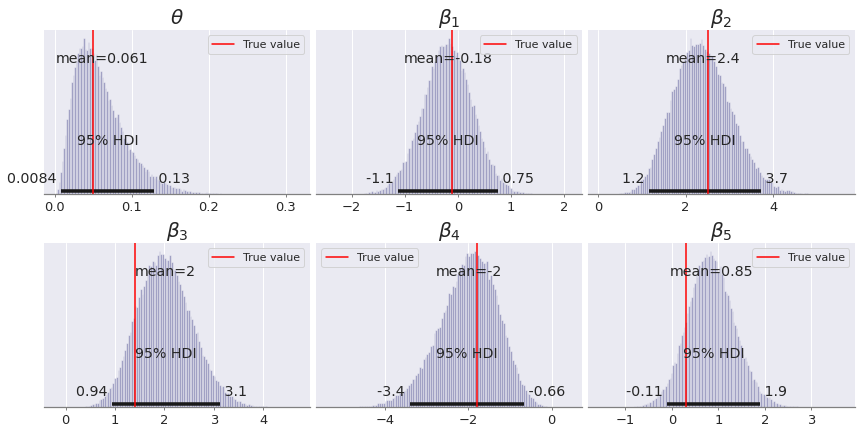

In [6]:
fig, ax = plt.subplots(2,3,figsize = (12,6))

az.plot_posterior(estimates_prev.flatten(), ax=ax[0,0], kind='hist', 
                  hdi_prob = 0.95, color = 'midnightblue', textsize = 13)
for k in range(5):
    i = (k+1) // 3
    j = (k+1) % 3
    az.plot_posterior(estimates_effects[:, k, :].flatten(), ax=ax[i,j], kind='hist', 
                      hdi_prob = 0.95, color = 'midnightblue', textsize = 13)

ax[0,0].set_title(r'$\theta$', fontsize = 20)
for k in range(5): 
    i = (k+1) // 3
    j = (k+1) % 3
    ax[i,j].set_title(r'$\beta_{}$'.format(k+1), fontsize = 20)
    
beta=np.array([-0.1, 2.5, 1.4, -1.8, 0.3])
for k, real in enumerate((0.05, *tuple(beta.flatten()))): 
    i = k // 3
    j = k % 3
    ax[i,j].axvline(real, color = 'red', label = 'True value')
    ax[i,j].legend()

fig.tight_layout(pad = 0.5)
#plt.savefig('../images/posteriors-including-uncertainty.pdf', bbox_inches = 'tight')
plt.show()

In [46]:
A = nx.adjacency_matrix(rds_sample['rds'].to_undirected()).toarray()
data.update({"adj_matrix": A, 
             "adj_pairs" : int(A.sum()//2)})

In [51]:
fit_imperfect_rds = sm.sampling(data=data, warmup=2500, iter=4000, chains=4, 
                                pars=('prev', 'effects'), 
                                control={'max_treedepth': 12})

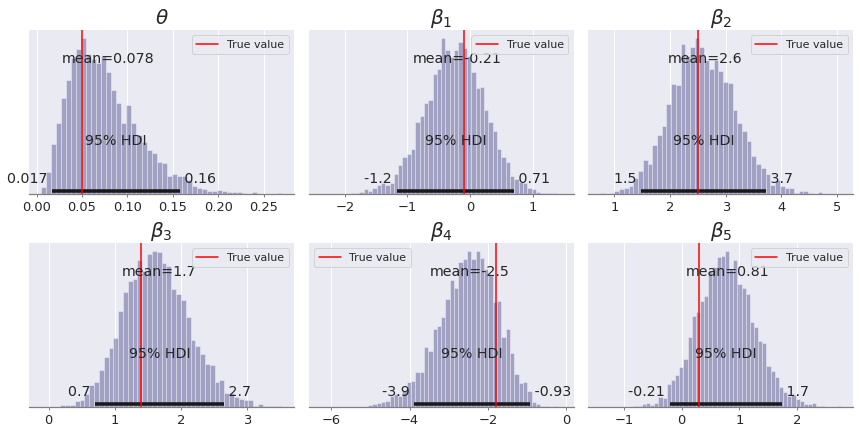

In [52]:
fig, ax = plt.subplots(2,3,figsize = (12,6))

az.plot_posterior(fit_imperfect_rds.extract()['prev'], ax=ax[0,0], kind='hist', 
                  hdi_prob = 0.95, color = 'midnightblue', textsize = 13)
for k in range(5):
    i = (k+1) // 3
    j = (k+1) % 3
    az.plot_posterior(fit_imperfect_rds.extract()['effects'][:,k].flatten(), ax=ax[i,j], kind='hist', 
                      hdi_prob = 0.95, color = 'midnightblue', textsize = 13)

ax[0,0].set_title(r'$\theta$', fontsize = 20)
for k in range(5): 
    i = (k+1) // 3
    j = (k+1) % 3
    ax[i,j].set_title(r'$\beta_{}$'.format(k+1), fontsize = 20)
    
beta=np.array([-0.1, 2.5, 1.4, -1.8, 0.3])
for k, real in enumerate((0.05, *tuple(beta.flatten()))): 
    i = k // 3
    j = k % 3
    ax[i,j].axvline(real, color = 'red', label = 'True value')
    ax[i,j].legend()

fig.tight_layout(pad = 0.5)
#plt.savefig('../images/posteriors-including-uncertainty.pdf', bbox_inches = 'tight')
plt.show()